# Learning *Pong!* from Pixels
________________________________________________________
In this notebook we will build a deep neural network with a mix of convolutional and fully-connected layers and we will train it to play Pong! using a Policy Network and REINFORCE. We will improve on the latter by using Future Rewards, Reward Normalisation and mini-batches, which allow us better credit assignment and learning stability.

## 0. Imports

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random as rand
import gym
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#!pip install progressbar
import progressbar as pb

## 1. Environment info
We're going to start with the 'Deterministic' version of Pong, which is just the standard version (no frame-skip tomfoolery). We're printing the actions available to us in Pong. The keys to them are their respective indexes and their meaning is:
- Noop: do nothing
- Fire: start
- Right/Left and RightFire/LeftFire: move right or left. The difference between Right/Left and RightFire/LeftFire is that if you lose a point, after Right/Left you need to hit the fire button to resume the game. RightFire/LeftFire move the paddle and hit the Fire button in the same action, obviating the need for the latter if you lose a point.

In [2]:
env = gym.make('PongDeterministic-v4')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("List of available actions: ", env.unwrapped.get_action_meanings())
print('Device is {}.'.format(device))
NOOP = 0
RIGHT = 4
LEFT = 5

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Device is cuda:0.


## 2. Preprocessing
We'll define a function for simplifying the sensory input fed to our neural network. ```preprocess``` accepts a list of frames and does the following:
- Crops the input to leave out gameplay-irrelevant elements (scoreboard, boundaries);
- Downsamples by a factor of 2 on XY and 3 on C (color) axes, reducing the image to a size of 80px x 80px x 1chan;
- Binarises the image by setting background to 0 and paddles/ball to 1; and
- Returns the list of n frames as a tensor of shape [1,2,80,80], ready to be fed into a torch neural network. In other words, that's a batch size of 1, 2 channels (temporal, since they're consecutive frames), 80 pixels on X and 80 pixels on Y.

In [29]:
def preprocess(frames, bg=(144,109)):
    i = np.asarray(frames)

    crop = [frame[35:195,:,:] for frame in i]
    downsample = np.asarray([frame[::2,::2,0] for frame in crop])
    for frame in downsample:
        frame[frame==bg[0]] = 0
        frame[frame==bg[1]] = 0
        frame[frame!=0] = 1
    
    #downsample = np.swapaxes(downsample,0,1)
    
    return torch.from_numpy(downsample).float().to(device).unsqueeze(0)

Let's have a look at an example with two frames.

Output of preprocess function is shaped torch.Size([1, 2, 80, 80]).


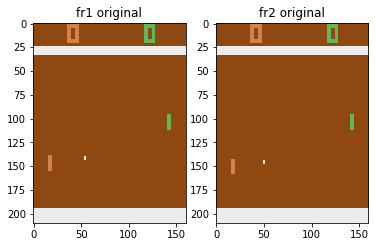

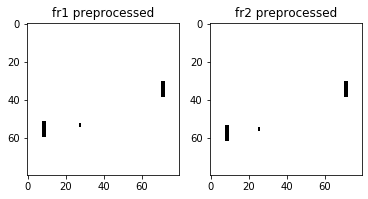

In [30]:
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    fr1, _, _, _ = env.step(1)
fr2, _, _, _ = env.step(0)

plt.subplot(2,2,1)
plt.imshow(fr1)
plt.title('fr1 original')
plt.subplot(2,2,2)
plt.imshow(fr2)
plt.title('fr2 original')

plt.figure()
plt.subplot(2,2,3)
plt.imshow(preprocess([fr1, fr2])[0,0].cpu(), cmap='Greys')
plt.title('fr1 preprocessed')
plt.subplot(2,2,4)
plt.imshow(preprocess([fr1, fr2])[0,1].cpu(), cmap='Greys')
plt.title('fr2 preprocessed')

print('Output of preprocess function is shaped {}.'.format(preprocess([fr1, fr2]).shape))

## 3. Defining the Policy Network
Now we define the architecture for our policy network. Convolutional layers make sense given the nature of visual stimuli the task involves. We shouldn't require more than 2 such layers, given the simplicity of stimuli involved and the types of feature detectors known to emerge in early convolutional layers (for example oriented edge detectors).  

The output of our last convolutional layer is flattened and sent to a fully-connected layer, before the final output. This should use as activation function a sigmoid, since we want to output a *probability* to perform the action 'RightFire'. In a way, we define our own action space by constraining the game's original (and somewhat redundant) 6-dimensional action space to 1 dimension. Knowing the probability of 'RightFire', we can define 'LeftFire' as 1 - p(RightFire), since we don't really want our agent to do Noop a lot.  

On my setup, the Adam optimizer with a learning rate of 2e-4 worked well.

In [28]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # output = (input - kernel + 2*padding)//stride +1
            # (80 - 6 + 2*0)//2 +1 = 38
                # (38 - 6 + 2*0)//4 +1 = 9
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16

        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))


policy=Policy().to(device)

optimizer = optim.Adam(policy.parameters(), lr=2e-4)

Quick example to check everything works well so far:

In [50]:
print('Passing 2 consecutive frames through "preprocess" and then passing those frames as \
input to the policy network.\n')

probabilities = policy.forward(x=preprocess([fr1, fr2]))

print('Output: {}.'.format(probabilities))

Passing 2 consecutive frames through "preprocess" and then passing those frames as input to the policy network.

Output: tensor([[0.5146]], device='cuda:0', grad_fn=<SigmoidBackward>).


## 4. Defining functions
We will define two functions:
```Python
def rollout_trajectories```
will make our agent play a pre-defined number of *Pong!* matches, saving the states, rewards, outputs of the policy network and actions taken, and
```Python
def loss```
will take these lists as input and produce a 'loss' tensor, which will be used for calculating gradients and updating the weights in our policy network.  

The code block below loss runs training epochs, allowing the user to set a range of hyperparameters and calling on the two functions above.
___________________
### 4.0. The big picture: what are we trying to do?


### 4.1. Collecting trajectories

In [338]:
nrand = 5
tmax = 320
bsize=4
gamma = 0.999
def rollout_trajectories(env, policy, tmax, nrand, bsize, render=False):
    states = []
    rewards = []
    probabilities = []
    actions = []
    
    for episode in range(bsize):
        env.reset()

        env.step(1)

        for _ in range(np.random.randint(2,nrand)):#range(nrand):
            fr1, _, _, _ = env.step(np.random.choice([RIGHT, LEFT]))
            fr2, _, _, _ = env.step(NOOP)

        for t in range(tmax):
            if render:
                env.render()
            x = preprocess([fr1, fr2])
            p = policy.forward(x)
            a = RIGHT if np.random.rand() < p.item() else LEFT#np.where(np.random.rand() < p.item(), RIGHT, LEFT)
            p = p if a == RIGHT else torch.tensor(1, device=device)-p#  np.where(a==RIGHT, p.item(), 1.0-p.item())

            fr1, r1, done, _ = env.step(a)
            fr2, r2, done, _ = env.step(NOOP)
            r = r1+r2

            states.append(x)
            rewards.append(r)
            probabilities.append(p)
            actions.append(a)

            if done:
                break
            
    return states, rewards, probabilities, actions

In [262]:
def loss(policy, states, rewards, probabilities, actions, tmax, bsize, gamma):
    discount = np.tile(gamma**np.arange(tmax), bsize)
    rewards = rewards * discount
    rewards = np.reshape(np.asarray(rewards), (tmax, bsize), order='F')
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    rmean = np.expand_dims(np.mean(rewards_future, axis=1),1)
    rstdv = np.expand_dims(np.std(rewards_future, axis=1),1)
    rewards_norm = ((rewards_future - rmean)/(rstdv+1e-10)).reshape((tmax*bsize), order='F')
    
    probabilities = torch.stack(probabilities).squeeze().to(device)
    rewards = torch.tensor(rewards_norm, dtype=torch.float, device=device)
    
    loss = []
    for r,l in zip(rewards, probabilities):
        loss.append(r*torch.log(l))
    
    loss = torch.stack(loss).mean()
    
    return loss

In [ ]:
bsize=8
tmax=125
gamma = 0.999
nrand = 5
scores = []
batches = 200
#200 tmax=100, 200 tmax=125

#policy=Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=2e-4)


widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=batches).start()


for batch in range(batches):
    
    states, rewards, probabilities, actions = rollout_trajectories(env, policy, tmax, nrand, bsize)
    
    total_rewards = np.sum(rewards)/bsize
    scores.append(total_rewards)
    
    L=-loss(policy, states, rewards, probabilities, actions, tmax, bsize, gamma)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    #del L
    
    print('Batch #{}/{}, score {}.'.format(batch+1, batches, total_rewards))
    
    timer.update(batch+1)
timer.finish()
torch.save(policy, 'pongReinforce_21032020.policy')
#batch_performance = []

Batch #1/200, score -3.875.


Batch #2/200, score -4.875.


Batch #3/200, score -4.5.


Batch #4/200, score -4.375.


Batch #5/200, score -4.375.


Batch #6/200, score -4.375.


Batch #7/200, score -4.5.


Batch #8/200, score -4.625.


Batch #9/200, score -4.375.


Batch #10/200, score -4.875.


Batch #11/200, score -4.5.


Batch #12/200, score -4.625.


Batch #13/200, score -4.625.


Batch #14/200, score -3.875.


Batch #15/200, score -4.875.


Batch #16/200, score -4.625.


Batch #17/200, score -5.25.


Batch #18/200, score -3.875.


Batch #19/200, score -4.375.


Batch #20/200, score -4.5.


Batch #21/200, score -4.625.


Batch #22/200, score -4.625.


Batch #23/200, score -4.75.


Batch #24/200, score -4.5.


Batch #25/200, score -5.0.


Batch #26/200, score -4.25.


Batch #27/200, score -4.125.


Batch #28/200, score -4.125.


Batch #29/200, score -5.125.


Batch #30/200, score -4.25.


Batch #31/200, score -4.375.


Batch #32/200, score -4.125.


Batch #33/200, score -4.125.


Batch #34/200, score -4.625.


Batch #35/200, score -4.625.


Batch #36/200, score -4.375.


Batch #37/200, score -4.625.


Batch #38/200, score -5.25.


Batch #39/200, score -4.625.


Batch #40/200, score -4.875.


Batch #41/200, score -4.375.


Batch #42/200, score -4.5.


Batch #43/200, score -5.0.


Batch #44/200, score -4.75.


Batch #45/200, score -4.875.


Batch #46/200, score -4.375.


Batch #47/200, score -4.75.


Batch #48/200, score -4.375.


Batch #49/200, score -5.0.


Batch #50/200, score -4.375.


Batch #51/200, score -4.875.


Batch #52/200, score -4.375.


Batch #53/200, score -4.5.


Batch #54/200, score -4.375.


Batch #55/200, score -4.75.


Batch #56/200, score -4.75.


Batch #57/200, score -4.375.


Batch #58/200, score -4.0.


Batch #59/200, score -4.875.


Batch #60/200, score -4.75.


Batch #61/200, score -4.875.


Batch #62/200, score -4.625.


Batch #63/200, score -4.375.


Batch #64/200, score -4.875.


Batch #65/200, score -4.625.


Batch #66/200, score -4.375.


Batch #67/200, score -4.25.


Batch #68/200, score -4.25.


Batch #69/200, score -3.5.


Batch #70/200, score -3.75.


Batch #71/200, score -4.375.


Batch #72/200, score -4.25.


Batch #73/200, score -3.875.


Batch #74/200, score -4.875.


Batch #75/200, score -4.875.


Batch #76/200, score -5.25.


Batch #77/200, score -5.0.


Batch #78/200, score -4.375.


Batch #79/200, score -4.75.


Batch #80/200, score -3.75.


Batch #81/200, score -4.375.


Batch #82/200, score -4.5.


Batch #83/200, score -4.75.


Batch #84/200, score -4.75.


Batch #85/200, score -4.875.


Batch #86/200, score -5.0.


Batch #87/200, score -4.125.


Batch #88/200, score -4.625.


Batch #89/200, score -4.25.


Batch #90/200, score -4.625.


Batch #91/200, score -4.25.


Batch #92/200, score -4.625.


Batch #93/200, score -4.625.


Batch #94/200, score -4.875.


Batch #95/200, score -4.375.


Batch #96/200, score -4.125.


Batch #97/200, score -3.75.


Batch #98/200, score -3.875.


Batch #99/200, score -5.125.


Batch #100/200, score -4.625.


Batch #101/200, score -4.75.


Batch #102/200, score -4.875.


Batch #103/200, score -3.625.


Batch #104/200, score -4.875.


Batch #105/200, score -4.875.


Batch #106/200, score -4.375.


Batch #107/200, score -4.875.


Batch #108/200, score -4.0.


Batch #109/200, score -4.625.


Batch #110/200, score -4.375.


Batch #111/200, score -4.5.


Batch #112/200, score -4.375.


Batch #113/200, score -5.0.


Batch #114/200, score -4.375.


Batch #115/200, score -4.0.


Batch #116/200, score -3.875.


Batch #117/200, score -4.625.


Batch #118/200, score -4.5.


Batch #119/200, score -4.0.


Batch #120/200, score -3.875.


Batch #121/200, score -4.625.


Batch #122/200, score -4.75.


Batch #123/200, score -4.375.


Batch #124/200, score -3.875.


Batch #125/200, score -4.25.


Batch #126/200, score -4.375.


Batch #127/200, score -3.875.


Batch #128/200, score -4.25.


Batch #129/200, score -4.0.


Batch #130/200, score -4.125.


Batch #131/200, score -3.875.


Batch #132/200, score -4.125.


Batch #133/200, score -4.625.


Batch #134/200, score -4.375.


Batch #135/200, score -4.75.


Batch #136/200, score -4.25.


Batch #137/200, score -4.375.


Batch #138/200, score -3.625.


Batch #139/200, score -4.75.


Batch #140/200, score -4.75.


Batch #141/200, score -3.75.


Batch #142/200, score -4.625.


Batch #143/200, score -4.125.


Batch #144/200, score -4.0.


Batch #145/200, score -4.125.


Batch #146/200, score -4.5.


Batch #147/200, score -4.375.


Batch #148/200, score -5.0.


Batch #149/200, score -3.875.


Batch #150/200, score -4.375.


Batch #151/200, score -4.375.


Batch #152/200, score -4.5.


Batch #153/200, score -5.0.


Batch #154/200, score -4.5.


Batch #155/200, score -4.75.


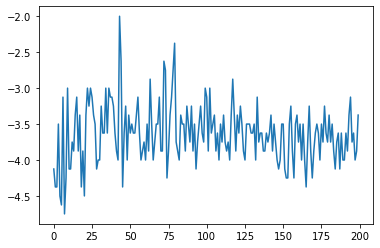

In [341]:
plt.plot(scores)
scores_epochs.append(scores)

In [342]:
tmaxplay=2000
_,rplay,_,actions=rollout_trajectories(env, policy, tmaxplay, nrand, bsize=4, render=True)
env.close()

won=[r for r in rplay if r==1]
lost=[r for r in rplay if r==-1]

print(sum(won)/4, -sum(lost)/4)

batch_performance.append((tmax, batches, sum(won)/4, -sum(lost)/4))

0.0 21.0


In [343]:
for i, m in enumerate(batch_performance):
    print('Batch # {}, trained {} time steps: average score {}-{}.'.format(i+1, m[0], m[2], m[3]))

(100, 200, 0.0, 21.0)